# Stellar objects identification with Machine Learning

### Inteligencia Artificial para los Sistemas de Control Autónomos
### Máster de Ciencia y Tecnología desde el Espacio


## Objectives

- Deal with an open Machine Learning problem.
- Classification of tabular unbalanced data.
- Hyperparameter optimization with grid and random search.
- Handle outliers.

## Introduction

The [Sloan Digital Sky Survey](https://www.sdss.org/) (or SDSS) is, according to [Wikipedia](https://en.wikipedia.org/wiki/Sloan_Digital_Sky_Survey), "a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States". It contains a huge database in which each night hundreds of gigabytes are added.

In this practice we will start from a data set of stellar objects to train a model that identifies the type of object it is from among three categories: Galaxy, star or quasar. The dataset contains 100.000 instances, it is unbalanced and contains a large number of outliers.

The features that the dataset contains are the following ones:

*    *obj_ID* = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
*    *alpha* = Right Ascension angle (at J2000 epoch)
*    *delta* = Declination angle (at J2000 epoch)
*    *u* = Ultraviolet filter in the photometric system
*    *g* = Green filter in the photometric system
*    *r* = Red filter in the photometric system
*    *i* = Near Infrared filter in the photometric system
*    *z* = Infrared filter in the photometric system
*    *run_ID* = Run Number used to identify the specific scan
*    *rereun_ID* = Rerun Number to specify how the image was processed
*    *cam_col* = Camera column to identify the scanline within the run
*    *field_ID* = Field number to identify each field
*    *spec_obj_ID* = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
*    *class* = object class (galaxy, star or quasar object)
*    *redshift* = redshift value based on the increase in wavelength
*    *plate* = plate ID, identifies each plate in SDSS
*    *MJD* = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
*    *fiber_ID* = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

In [1]:
import pandas as pd

df = pd.read_csv("https://github.com/dfbarrero/dataCourse/raw/master/assignments/stellar/stellar.zip")

df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

## Exercise: EDA

In [2]:
print("Número de instancias:", df.shape[0])
print("Número de atributos:", df.shape[1])

print("\nAtributos:", df.columns.to_list())
print("\nValores NaN:\n", df.isna().sum())
print("\nValores nulos:\n", df.isnull().sum())

print("\nResumen estadístico:\n", df.describe())

Número de instancias: 100000
Número de atributos: 18

Atributos: ['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift', 'plate', 'MJD', 'fiber_ID']

Valores NaN:
 obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

Valores nulos:
 obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

Resumen estadístico:
              obj_ID          alpha          delta              u  \
count  1.00

## Exercise: Data cleaning

Locate the outliers in the dataset and remove them. There are many methods you can use, one quite easy is to visualize a boxplot or histogram of each attribute and drop those values that are too high or low. You also should remove irrelevant or redundant attributes.

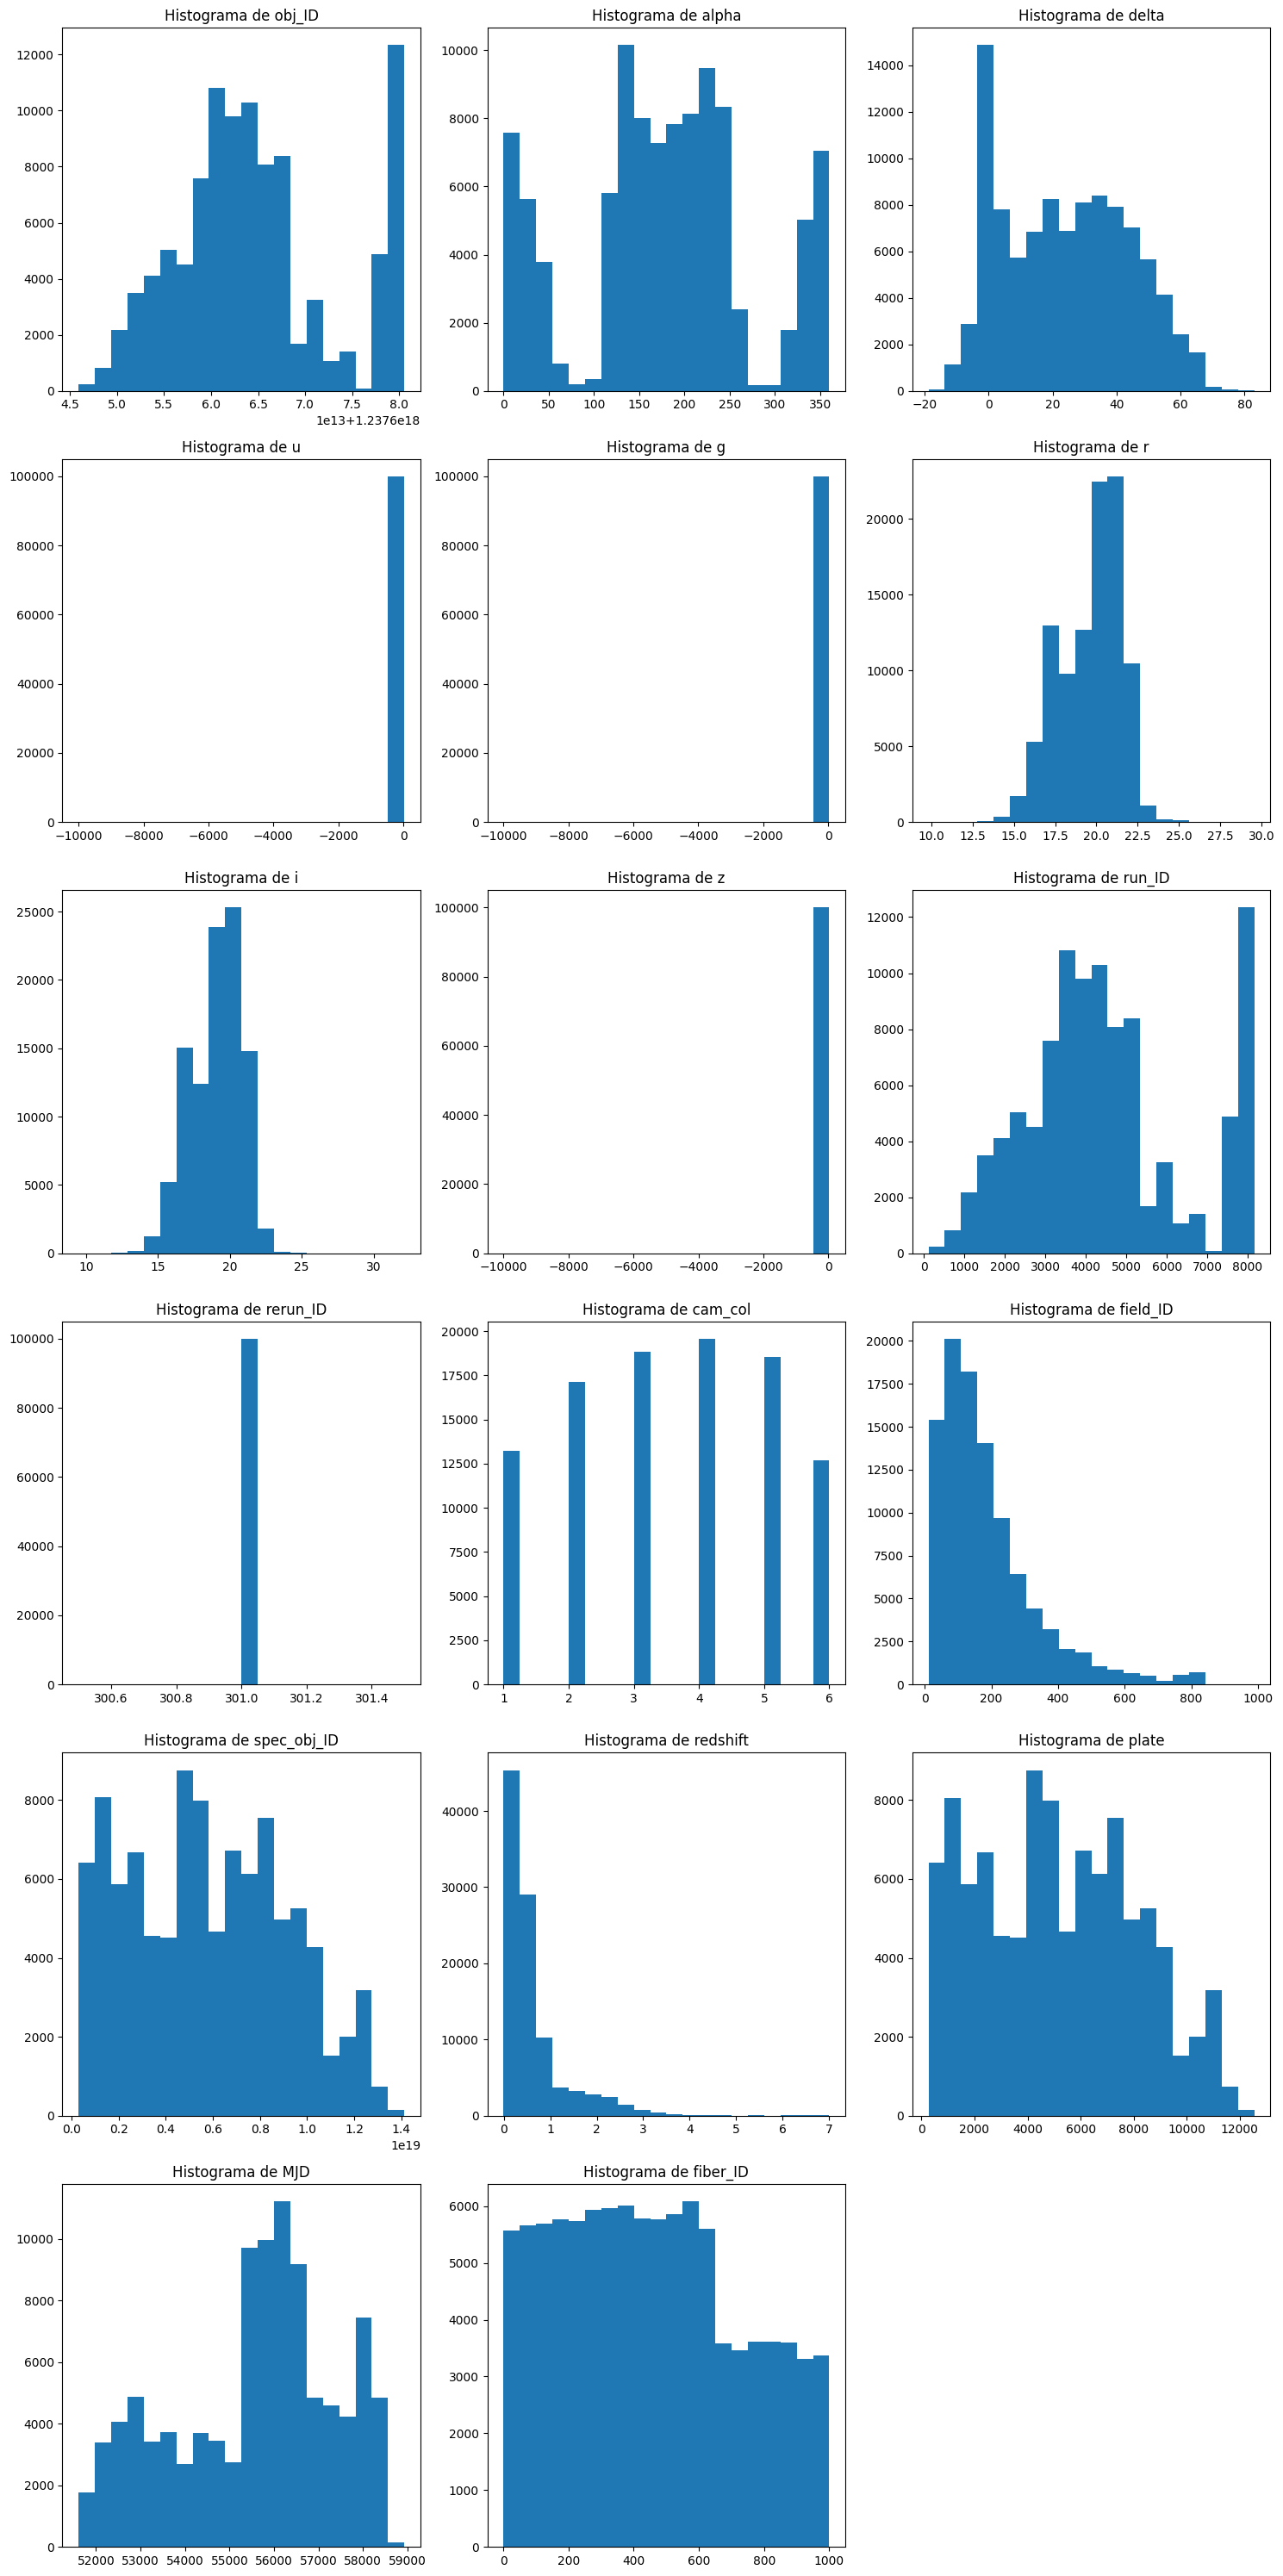

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener las columnas numéricas
numerical_cols = df.select_dtypes(include=np.number).columns

# Calcular el número de filas y columnas para la cuadrícula
num_cols = 3  # Número de columnas en la cuadrícula
num_rows = int(np.ceil(len(numerical_cols) / num_cols)) # Número de filas, ajustando al techo

# Crear la figura y los subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Aplanar los axes para iterar fácilmente
axes = axes.flatten()

# Iterar sobre las columnas numéricas y crear los histogramas
for i, col in enumerate(numerical_cols):
    axes[i].hist(df[col], bins=20)
    axes[i].set_title(f'Histograma de {col}')

# Ocultar los subplots adicionales si hay menos columnas que espacios en la cuadrícula
for i in range(len(numerical_cols), len(axes)):
    axes[i].axis('off')

# Ajustar el espaciado entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

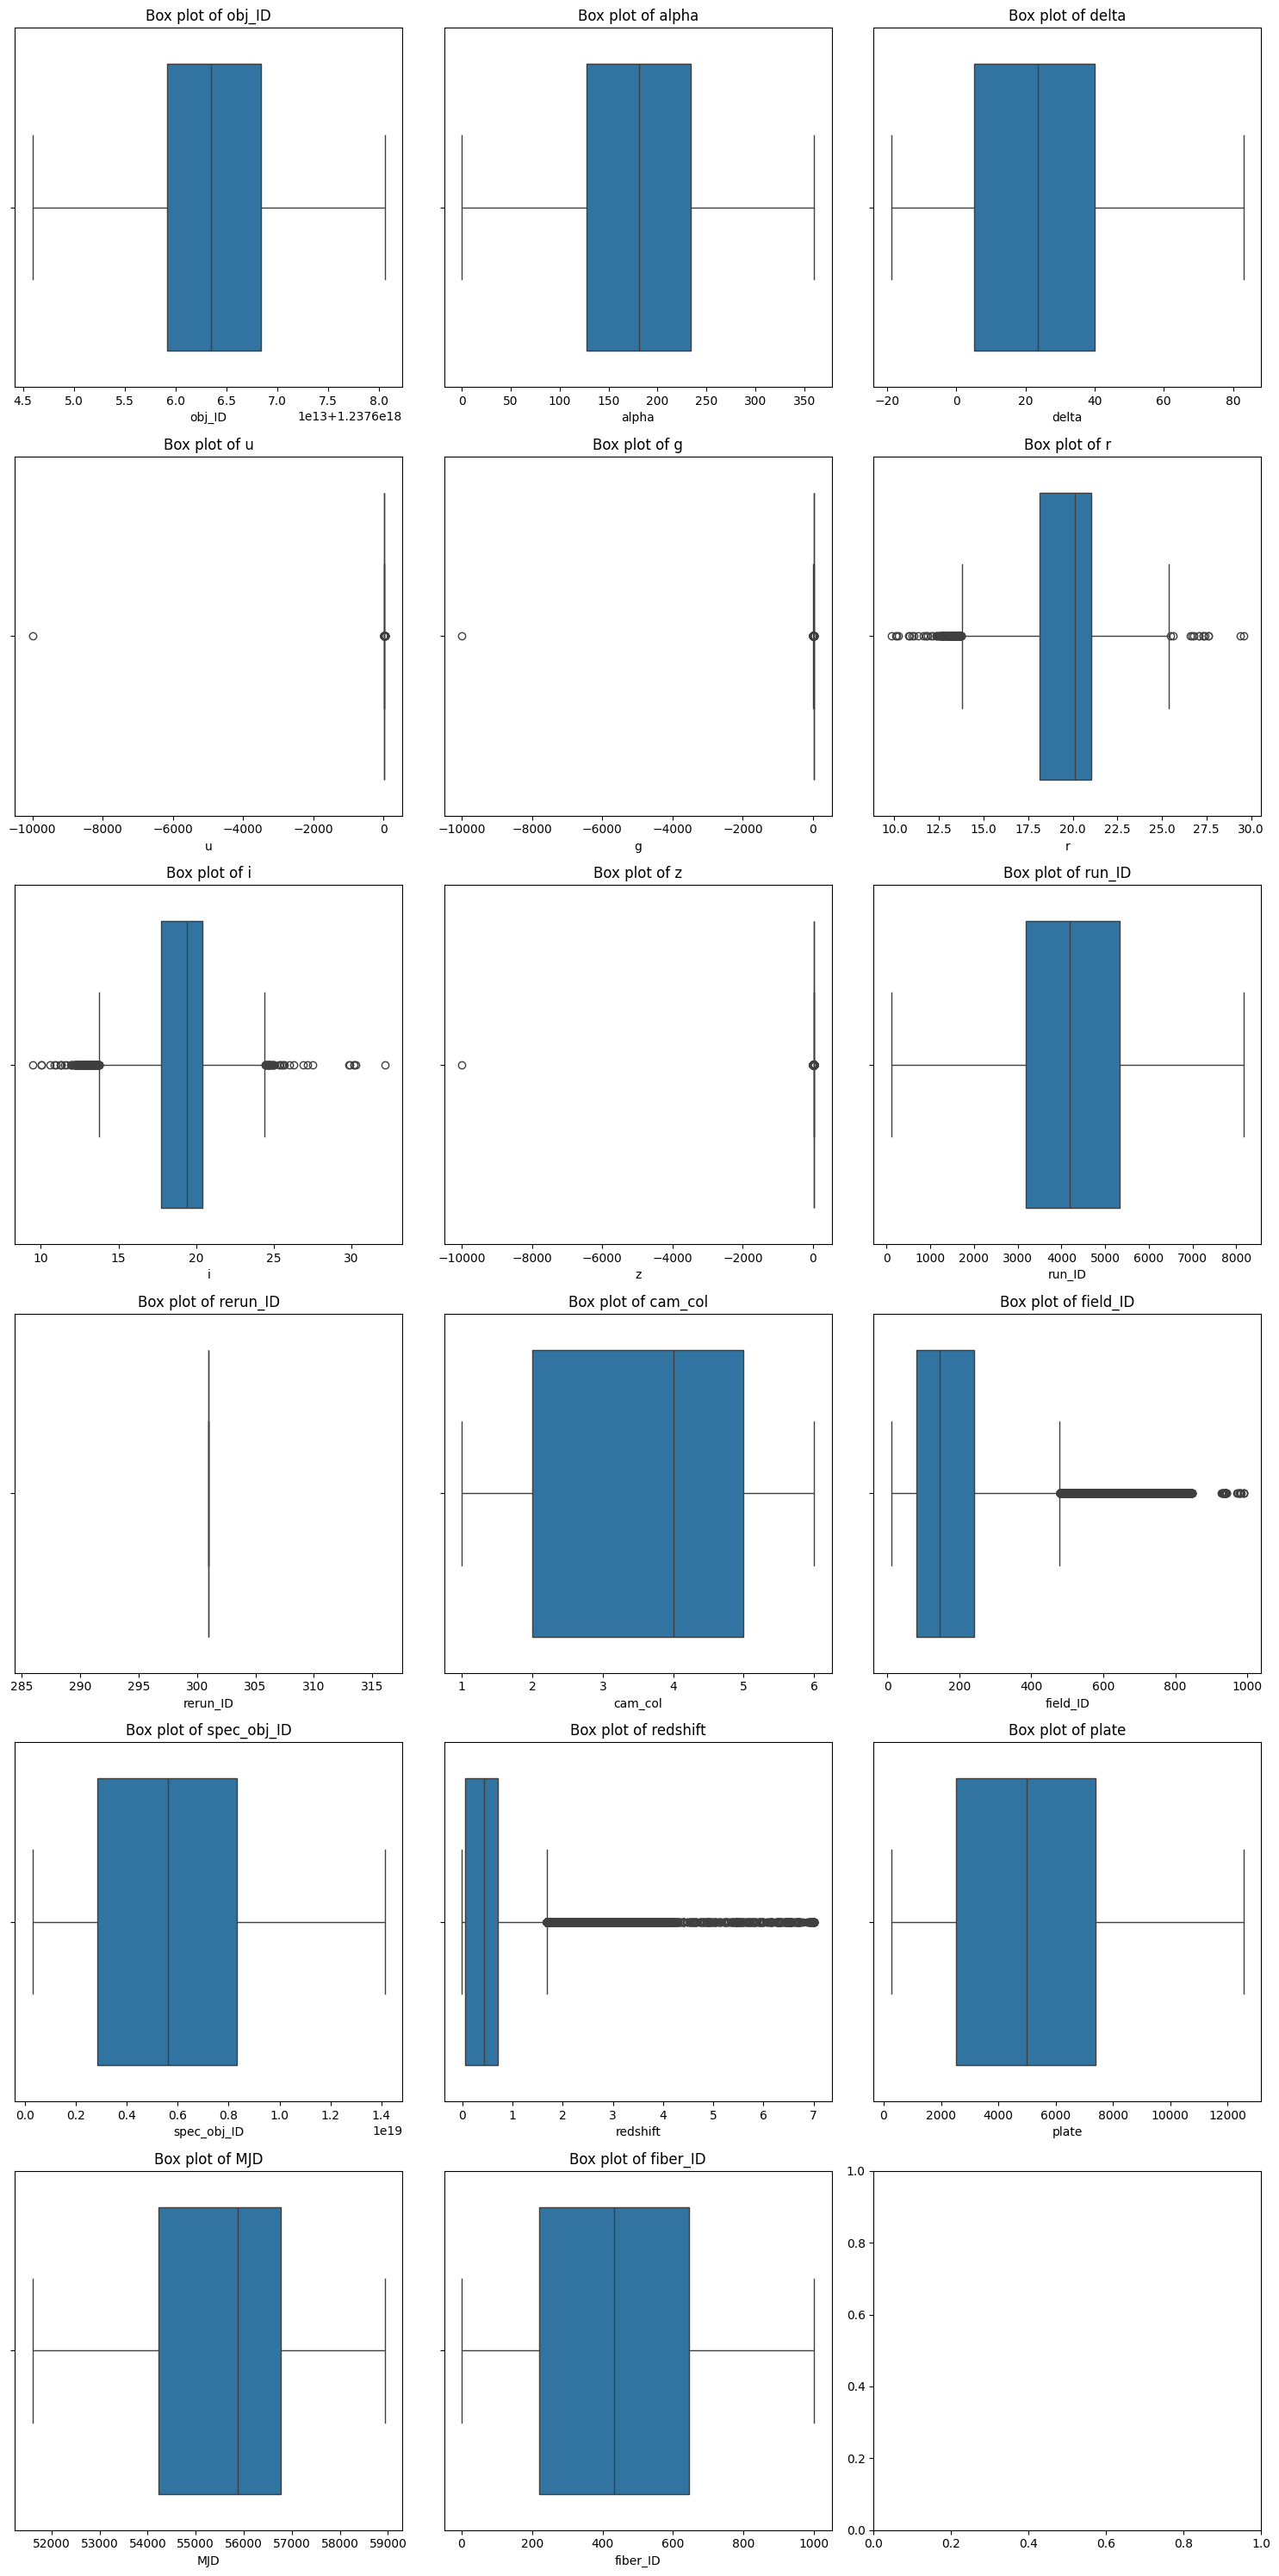

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'df' is your DataFrame
numerical_cols = df.select_dtypes(include=np.number).columns

# Calculate the number of rows and columns for the grid
num_cols = 3  # Number of columns in the grid
num_rows = int(np.ceil(len(numerical_cols) / num_cols))  # Number of rows

# Create the figure and axes in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Iterate over the numerical columns and create the box plots
for i, col in enumerate(numerical_cols):
    row = i // num_cols  # Calculate the current row
    col_num = i % num_cols  # Calculate the current column
    ax = axes[row, col_num]  # Get the current axis

    sns.boxplot(x=df[col], ax=ax)  # Create box plot on the current axis
    ax.set_title(f'Box plot of {col}')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure with all box plots
plt.show()

## Dealing with unbalanced classes
There are several actions that can be taken to address an unbalanced dataset, the best approach will depend on the problem and the data itself.

The classical accuracy used in classification, when there is unbalanced classes, looses reliability. Imagine, for instance, a dataset with 99% of instances of a class A, and only 1% of class B. If we apply a dummy classifier that classifies everything as A, we will obtain an accuracy of 99%, which suggests excellent performance, but clearly this classifier will not be working correctly. For this reason accuracy is rarely used with unbalanced datasets.

One of the most commonly used metrics with unbalanced data is F1, which is defined as the harmonic mean of the precision and recall:

$F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$.

F1 is defined in a range from zero to one, with one corresponding to a perfect classification. The definition is made for binary classification problems, so it needs to be adapted to multi-label problems like the one we are dealing with. Scikit applies F1 to each class separately, obtaining several F1 values, which it then groups by means of an average. There are several methods to do this grouping. More information in [Scikit-Learn reference documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

Another approach to deal with an unbalanced dataset is to make it a balanced one. The most straightforward way to this is to simply undersample the majority class or oversample the minority class. A variation of the latter is to add noise to the oversampling in a controlled way, so as to bring more variety to the dataset, avoiding overlearning. In the context of Deep Learning this technique is known as "data augmentation".

<img align="center" src="https://github.com/dfbarrero/dataCourse/blob/master/assignments/stellar/smote.webp?raw=1" width="300">

More advanced techniques involve synthetically generating new instances of the minority class. For example, [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) is a technique of some sophistication and quite popular that creates new instances of the minority class by sampling the straight line joining a minority class instance with some close neighbor.

SMOTE is not supported by Sckit-Learn, we need another library named imblearn.

In [5]:
!pip install imblearn

In [6]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE


df = pd.read_csv("https://github.com/dfbarrero/dataCourse/raw/master/assignments/stellar/stellar.zip")
print(df['class'].value_counts())

x = df.drop(['class'], axis = 1)
y = df.loc[:,'class'].values

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64


In [7]:
smote= SMOTE()
x_smote, y_smote = smote.fit_resample(x, y)

print(np.unique(y_smote, return_counts=True))

del x_smote, y_smote
del df, x, y

(array(['GALAXY', 'QSO', 'STAR'], dtype=object), array([59445, 59445, 59445]))


## Exercise: Predictive modeling

Train a classifier to identify if a certain object is a galaxy, quasar or star. You can use any technique of your choice to deal with the unbalanced dataset and try, at least, five classifiers. Obtain the best classifier you can without sophisticated hyperparameter optimization.

In [ ]:

# YOUR CODE HERE


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE

# 1. Data Preparation
df = pd.read_csv("https://github.com/dfbarrero/dataCourse/raw/master/assignments/stellar/stellar.zip")
# ... (Your data cleaning and preprocessing code) ...
X = df.drop('class', axis=1)
y = df['class']

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)  # You can adjust the random_state
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 2. Model Selection and Training
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # 3. Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'{name}:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-score: {f1:.4f}')
    print(classification_report(y_test, y_pred))

Logistic Regression:
  Accuracy: 0.4922
  F1-score: 0.4594
              precision    recall  f1-score   support

      GALAXY       0.44      0.17      0.25     11806
         QSO       0.51      0.68      0.58     11865
        STAR       0.49      0.62      0.55     11996

    accuracy                           0.49     35667
   macro avg       0.48      0.49      0.46     35667
weighted avg       0.48      0.49      0.46     35667

Decision Tree:
  Accuracy: 0.9744
  F1-score: 0.9744
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     11806
         QSO       0.96      0.96      0.96     11865
        STAR       1.00      1.00      1.00     11996

    accuracy                           0.97     35667
   macro avg       0.97      0.97      0.97     35667
weighted avg       0.97      0.97      0.97     35667

Random Forest:
  Accuracy: 0.9847
  F1-score: 0.9847
              precision    recall  f1-score   support

      GALAXY      

## Hyperparameter optimization

The performance of the models depends strongly on the hyperparameters, which is more clear when dealing with real-world problems. Since performance can be quantified, we can view this problem as a pure optimization problem, for which there are a multitude of techniques in AI.

<center> Grid search <img align="center" src="https://github.com/dfbarrero/dataCourse/blob/master/assignments/stellar/grid.png?raw=1" width="300"></center>

One of the most widely used hyperparameter optimization techniques in Machine Learning is provided by the Scikit-Learn function *GridSearchCV()*, which is provided with the hyperparameters to be optimized and a range of values to be searched. The function creates a combination of hyperparameters and trains the model with each combination, returning the combination that performs best. It can apply cross-validation if required to.

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

iris = datasets.load_iris()

parameters = {'kernel':('linear', 'rbf'),
              'C':[1, 10]}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(iris.data, iris.target)

print(f"Best params: {clf.best_params_}")
print(f"Best score: {clf.best_score_}")

Please observe that [*GridSearchCV()*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) returns an object that contains the result of the search, but behaves like a model.

<center>Random search <img align="center" src="https://github.com/dfbarrero/dataCourse/blob/master/assignments/stellar/random.png?raw=1" width="300"></center>

Since the search space increases exponentially with the number of hyperparameters to be optimized, grid search becomes computationally intractable with some ease. A randomized search may be useful in these cases ([see *RandomizedSearchCV()*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)), or other much more advanced methods such as bayesian optimization or even Genetic Algorithms.

## Exercise: Predictive modeling with hyperparameter optimization (optional)

Get the best classifier you can.

In [ ]:

# YOUR CODE HERE
